In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


from importlib import reload


import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *
from scoobpsf import scoob

import lina

pupil_diam = 6.75*u.mm 
lyot_diam = 8.7*u.mm

wavelength_c = 632.8e-9*u.m # central wavelength
npix = 512
oversample = 8

reload(scoobpsf.agpm)
vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0)
wfs_lyot_stop = poppy.InverseTransmission(lyot_stop)


In [2]:
reload(scoob)
model = scoob.SCOOBM()

reload(scoobpsf.agpm)
vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)

model.npix = 256
model.oversample = 32


No OPD data implemented into model.
Using default Gaussian influence function.
Including factor of 2 from reflection when computing OPD.


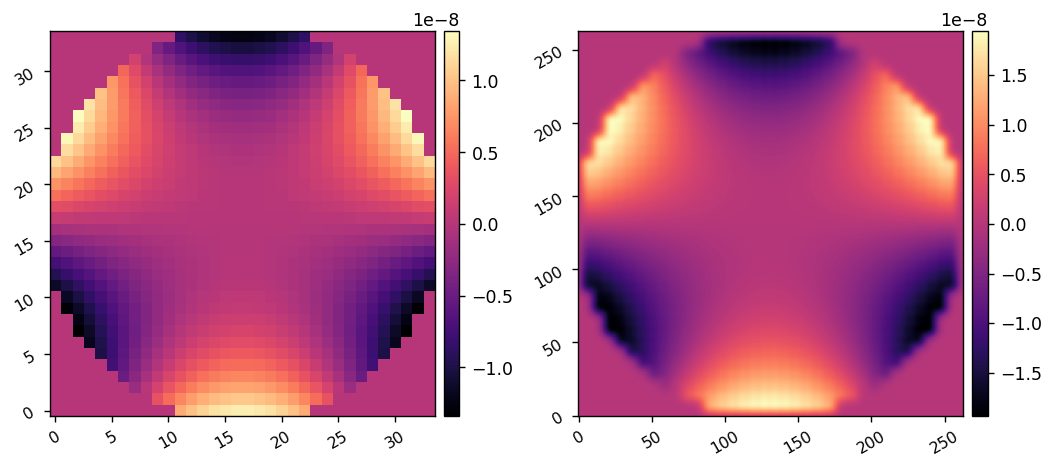

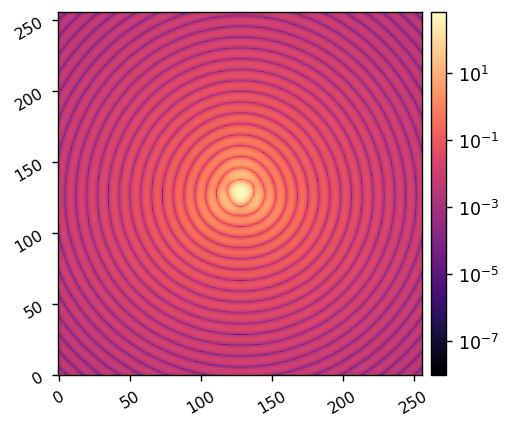

In [3]:
nmodes = 25
# wf = poppy.Wavefront(diam=model.pupil_diam, npix=512, oversample=1)
# pupil_mask = poppy.CircularAperture(radius=model.pupil_diam/2, name='Pupil').get_transmission(wf).astype(bool)

# reload(lina.llowfsc)
# zmodes = lina.llowfsc.create_zernike_modes(pupil_mask, nmodes=15)[1:]
# imshow2(pupil_mask, zmodes[7])

dm_zernikes = lina.llowfsc.create_zernike_modes(model.dm_mask, nmodes=25 + 1)[1:]
model.set_dm(dm_zernikes[7]*5e-9)
imshow2(dm_zernikes[7]*5e-9, model.DM.get_surface())

im = model.snap()
imshow1(im, lognorm=True)
model.reset_dm()




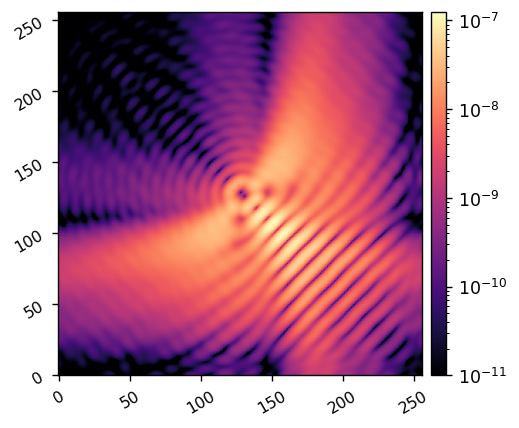

In [4]:
model.Imax_ref = model.snap().max()

ref_psf = model.snap()

model.FPM = vortex
model.LYOT = lyot_stop

ref_im = model.snap()
imshow1(ref_im, lognorm=True, vmin=1e-11)

In [5]:
model.use_llowfsc = True
model.llowfsc_defocus = 2*u.mm
model.nllowfsc = 64

model.FPM = vortex
model.LYOT = wfs_lyot_stop


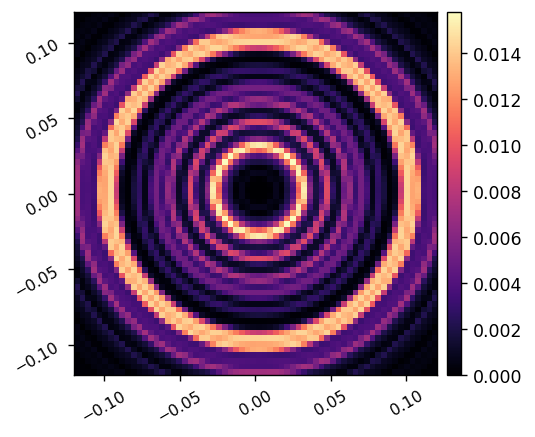

In [44]:
model.reset_dm()
im = model.snap()
imshow1(im, pxscl=model.llowfsc_pixelscale.to(u.mm/u.pix))

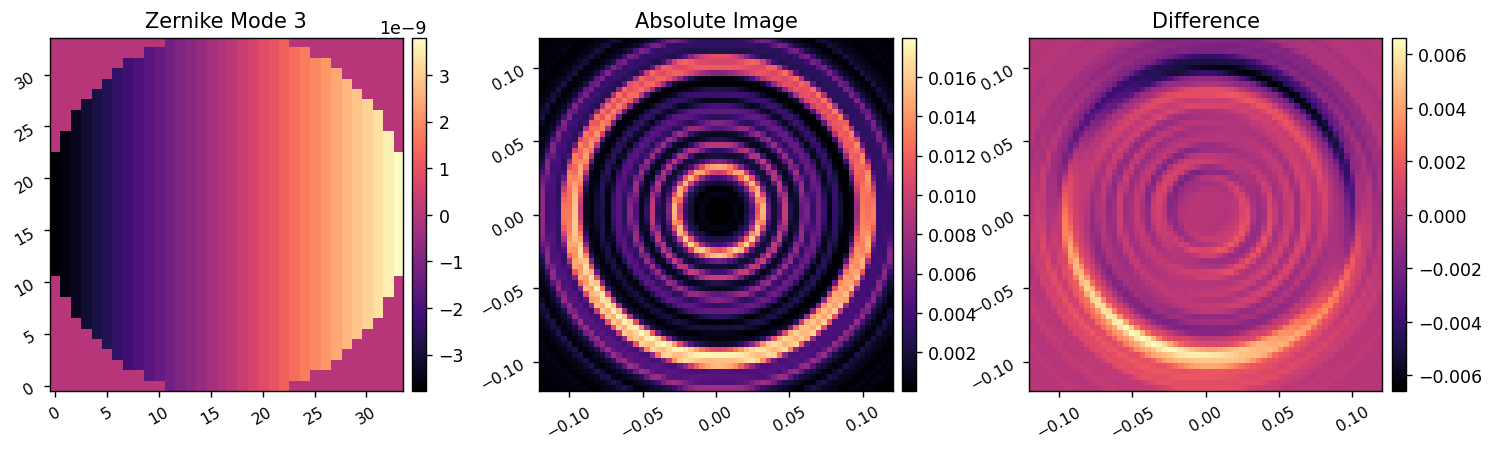

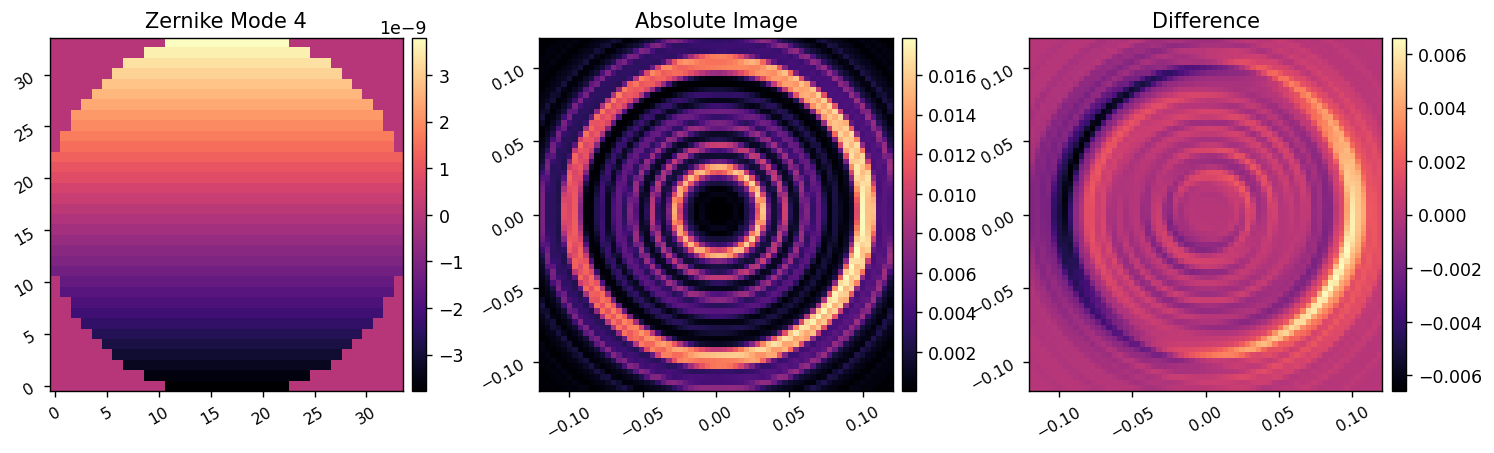

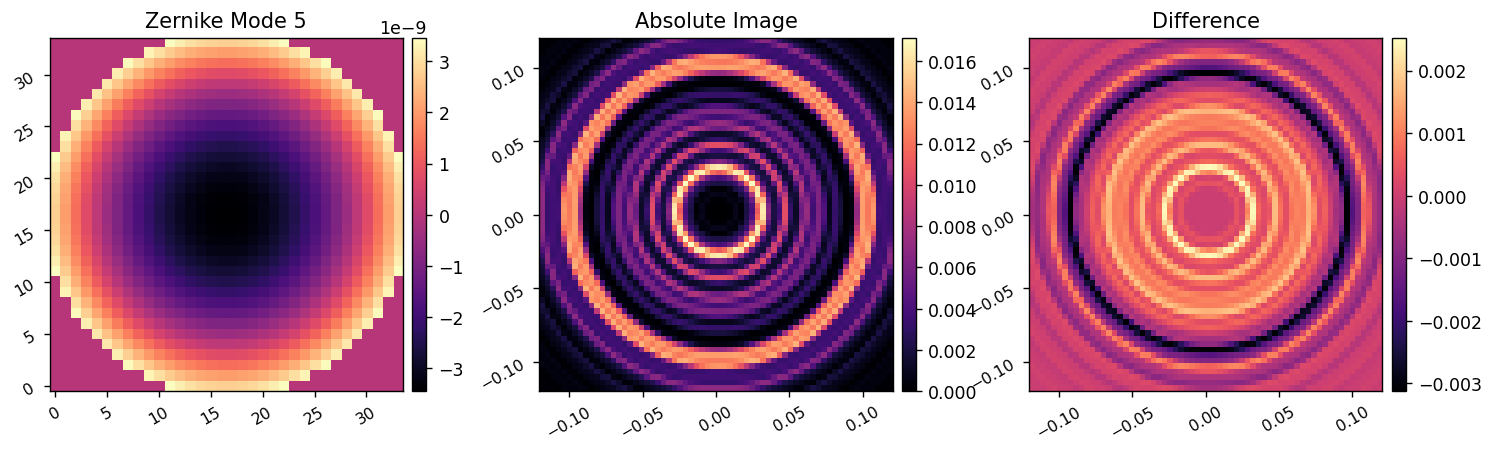

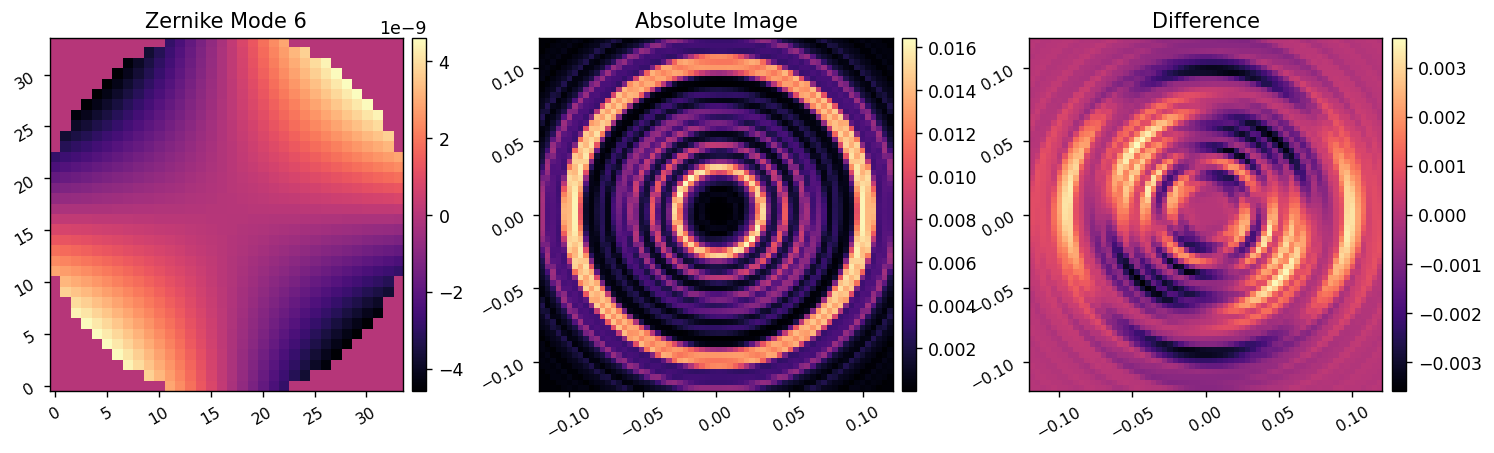

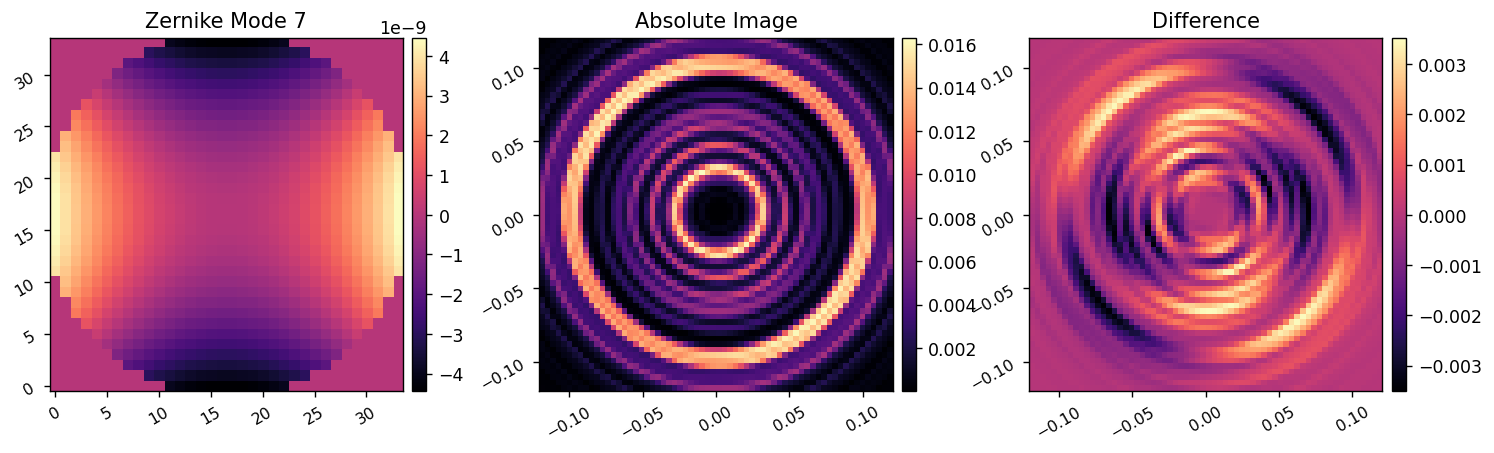

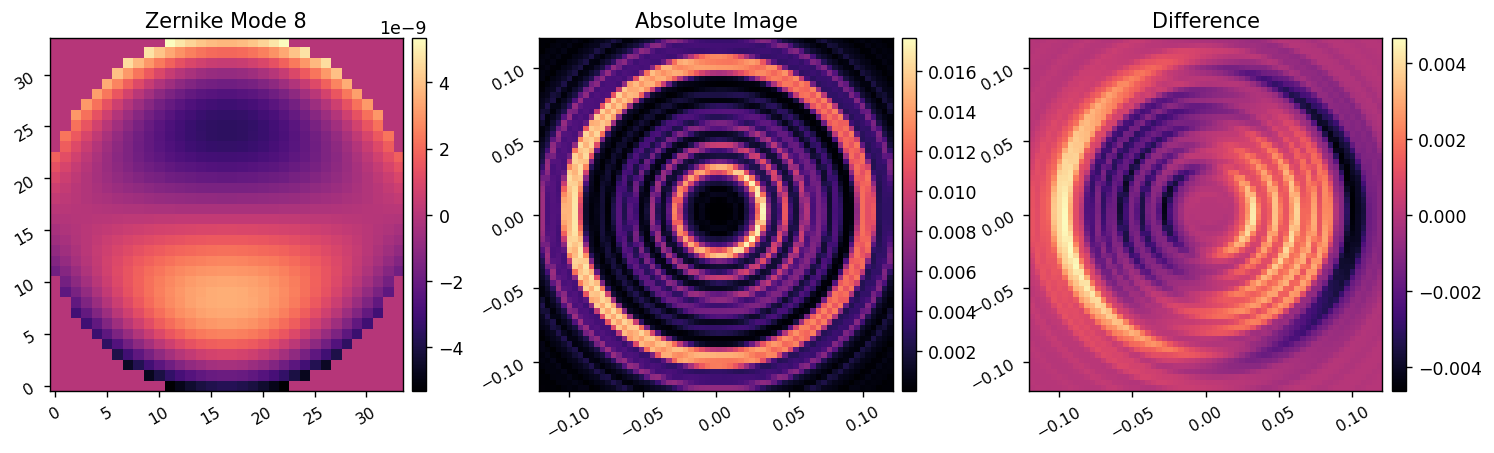

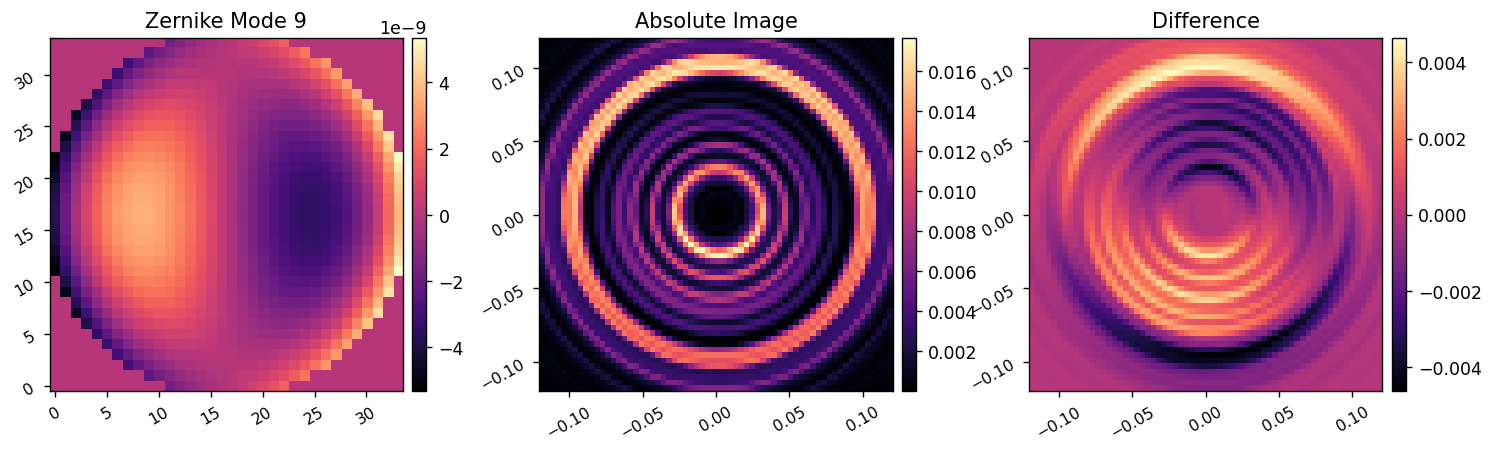

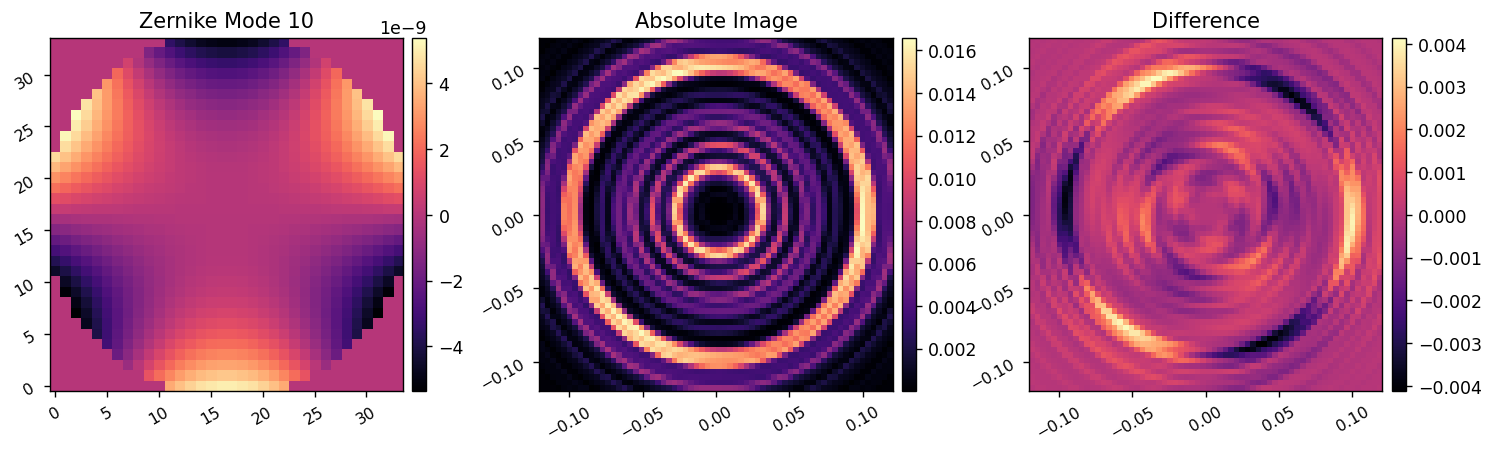

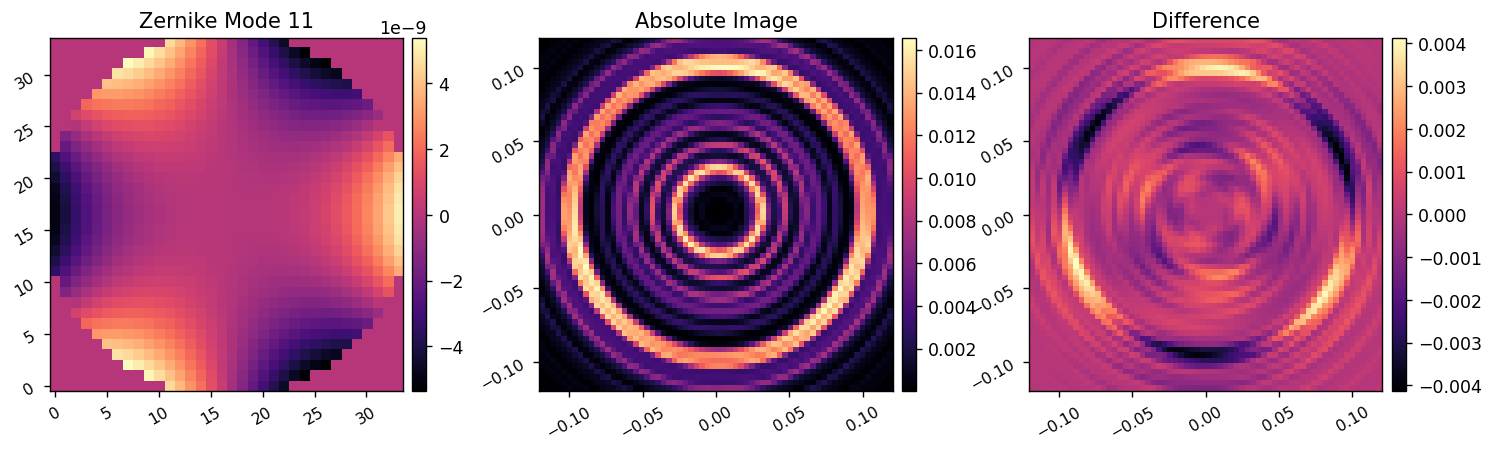

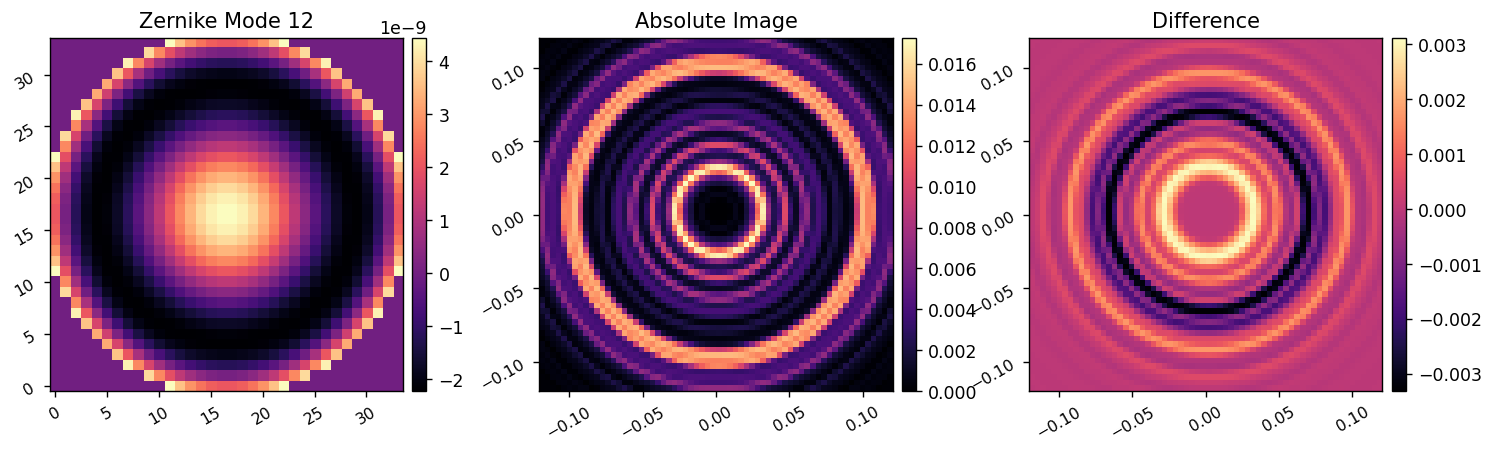

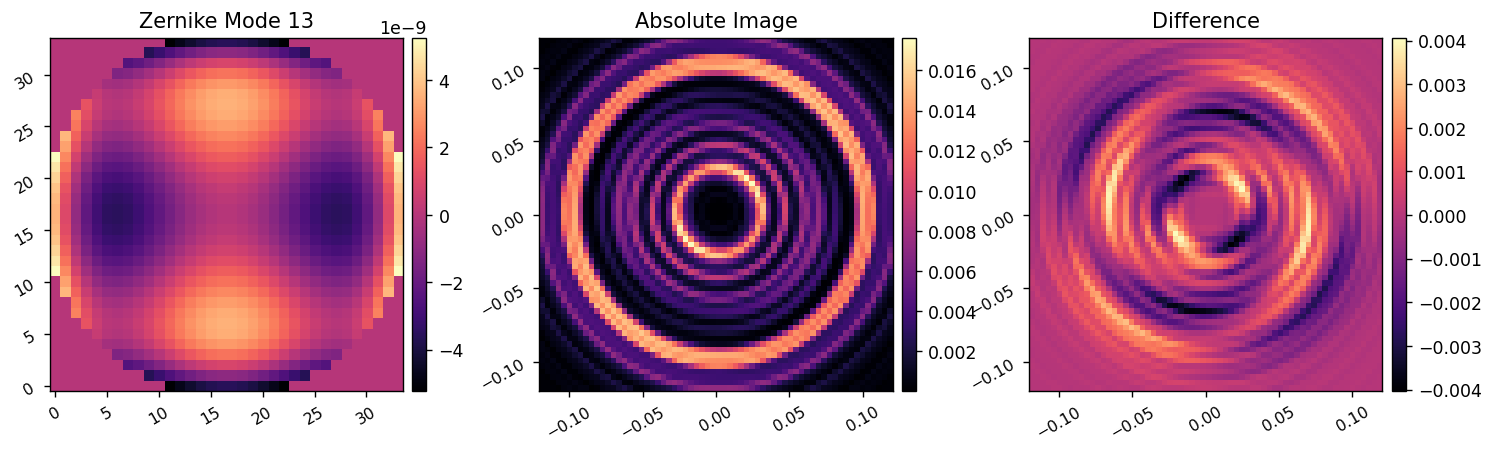

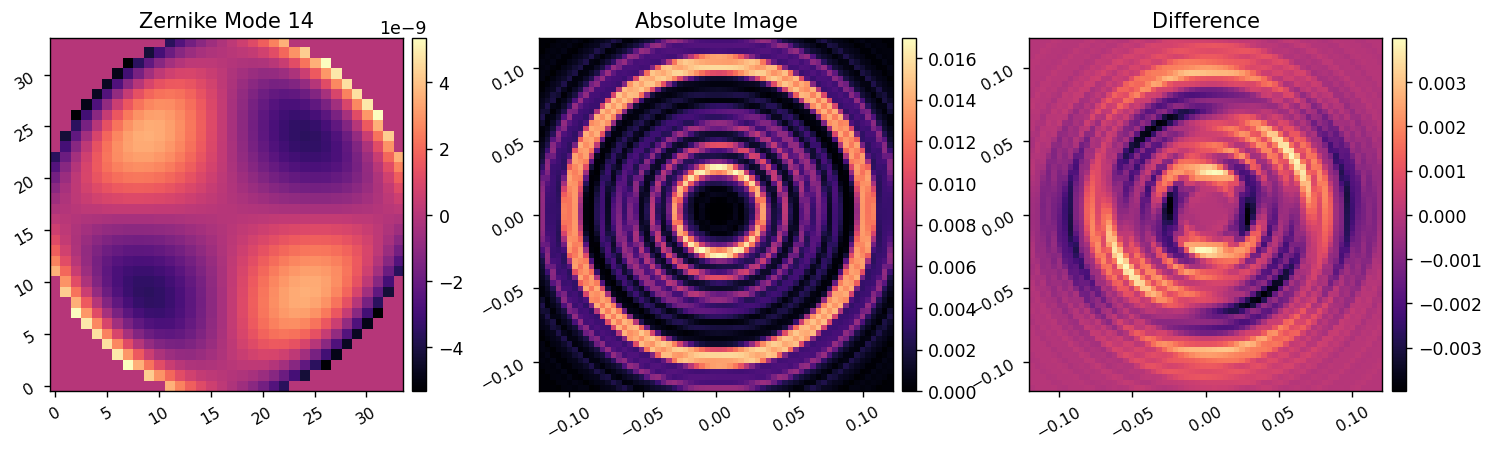

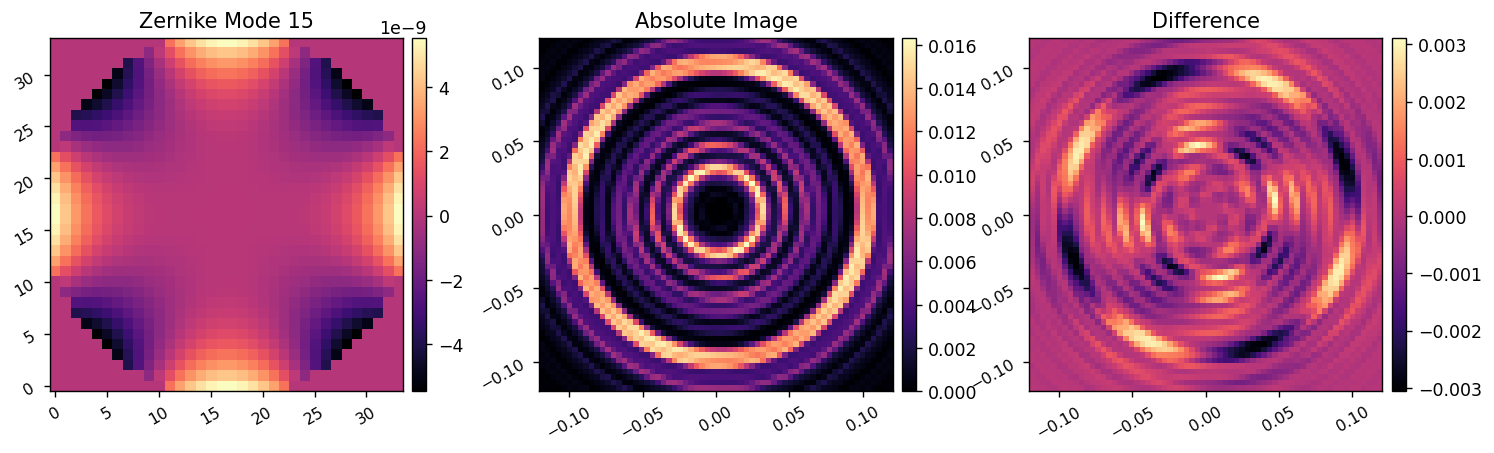

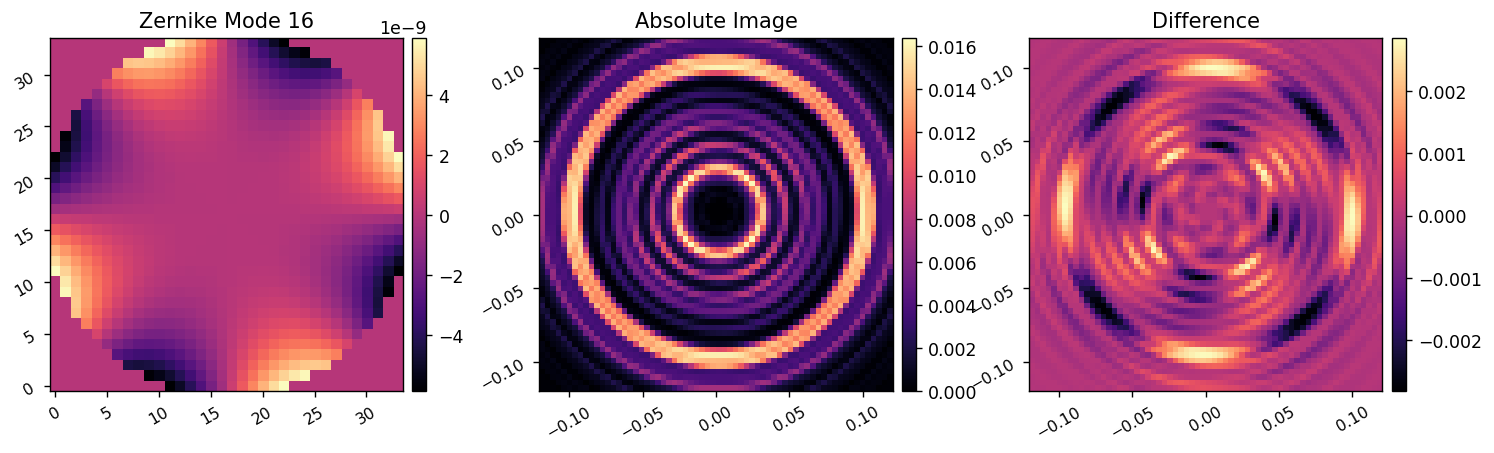

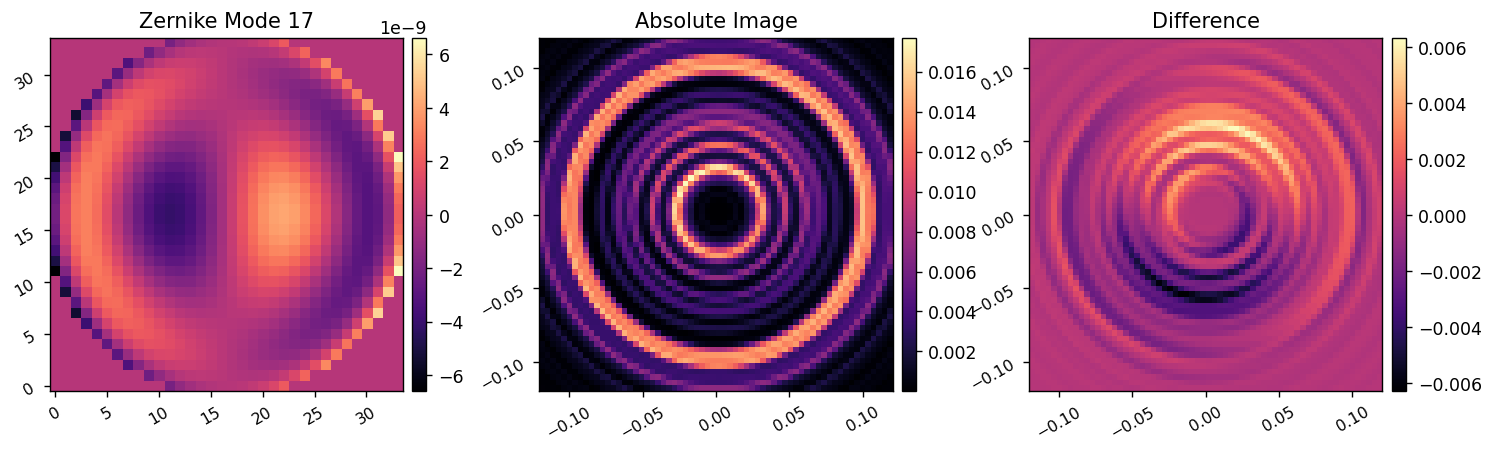

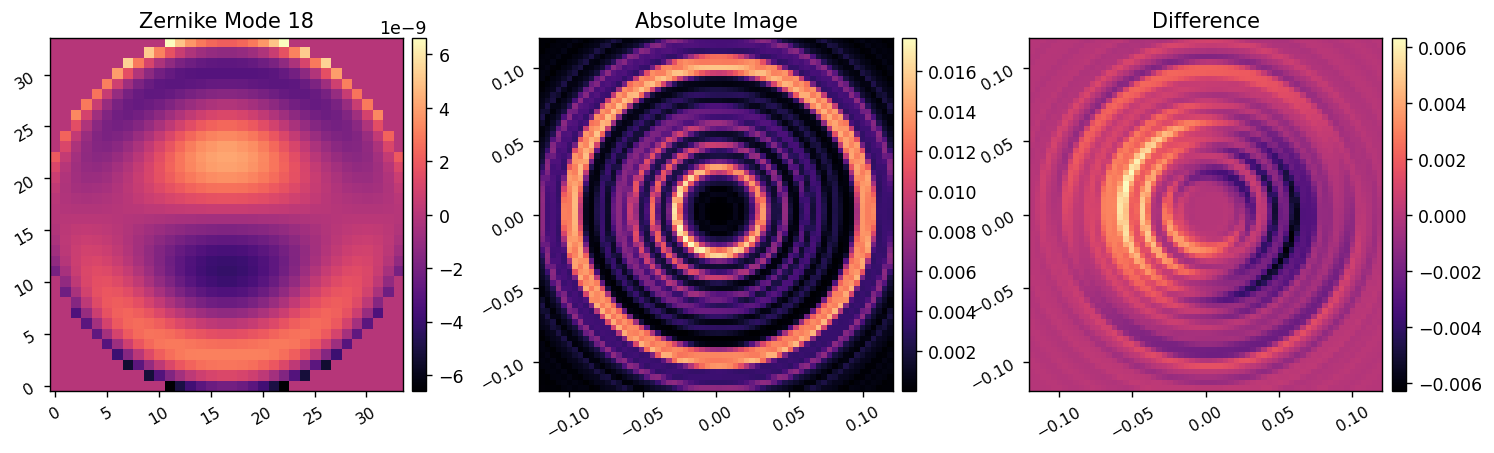

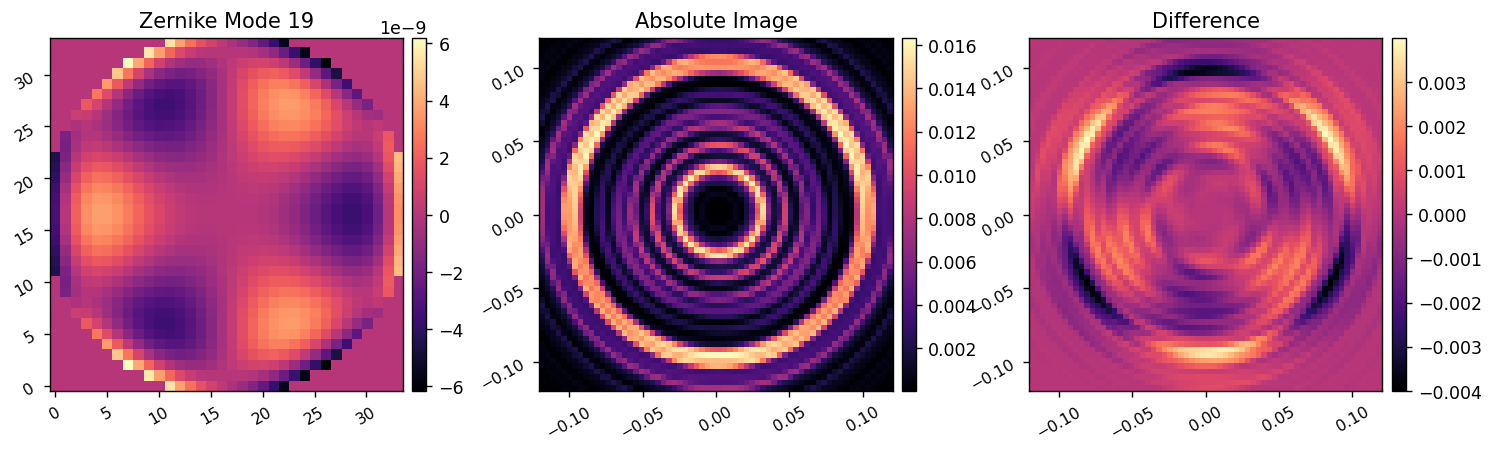

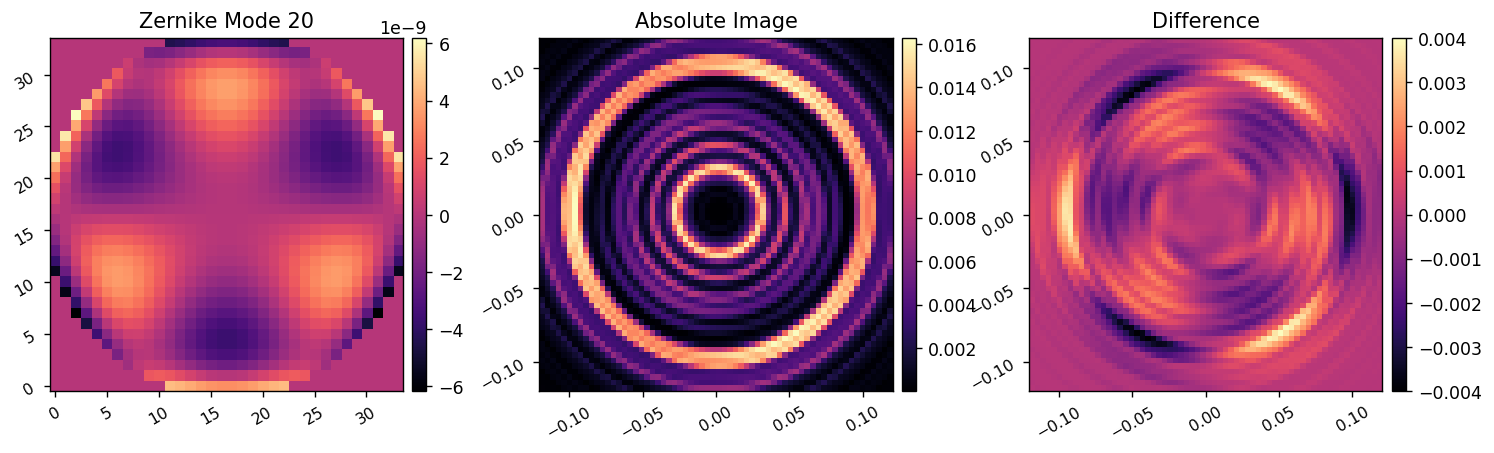

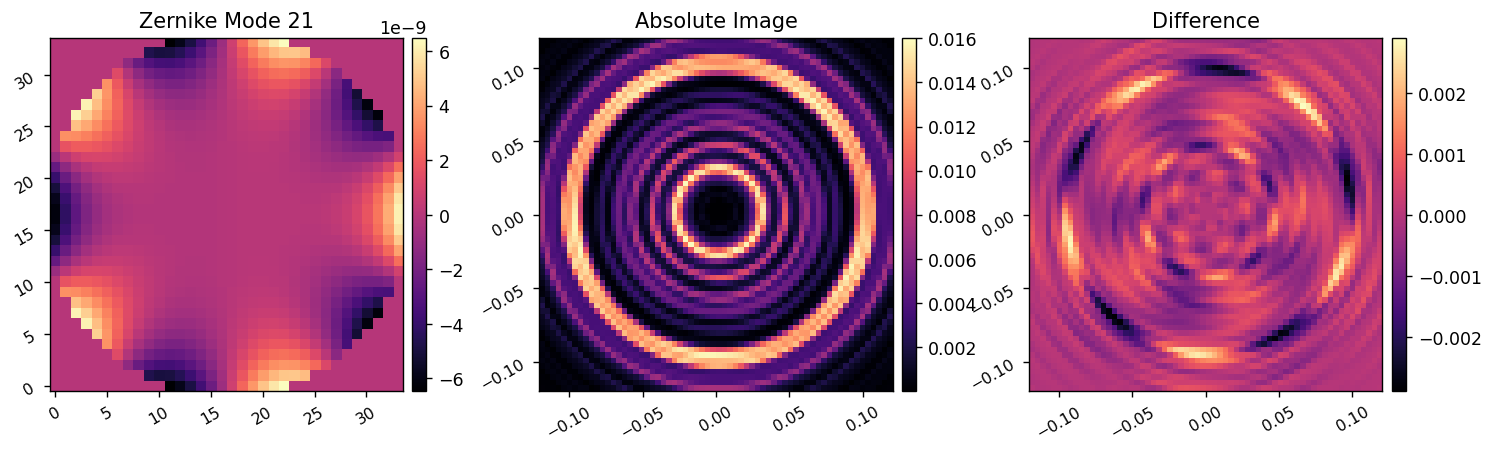

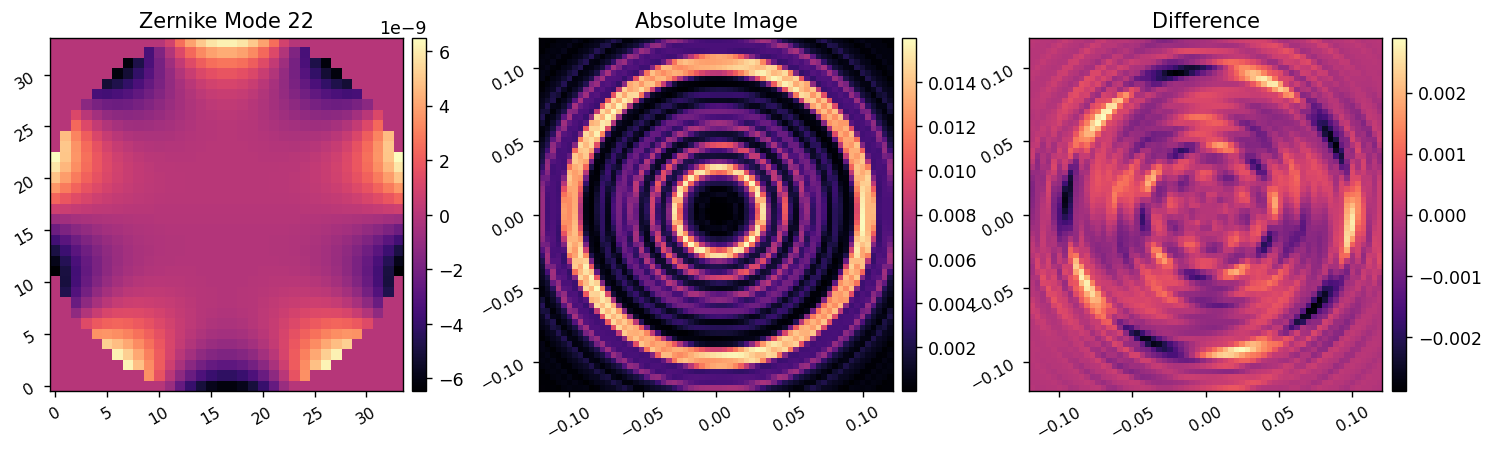

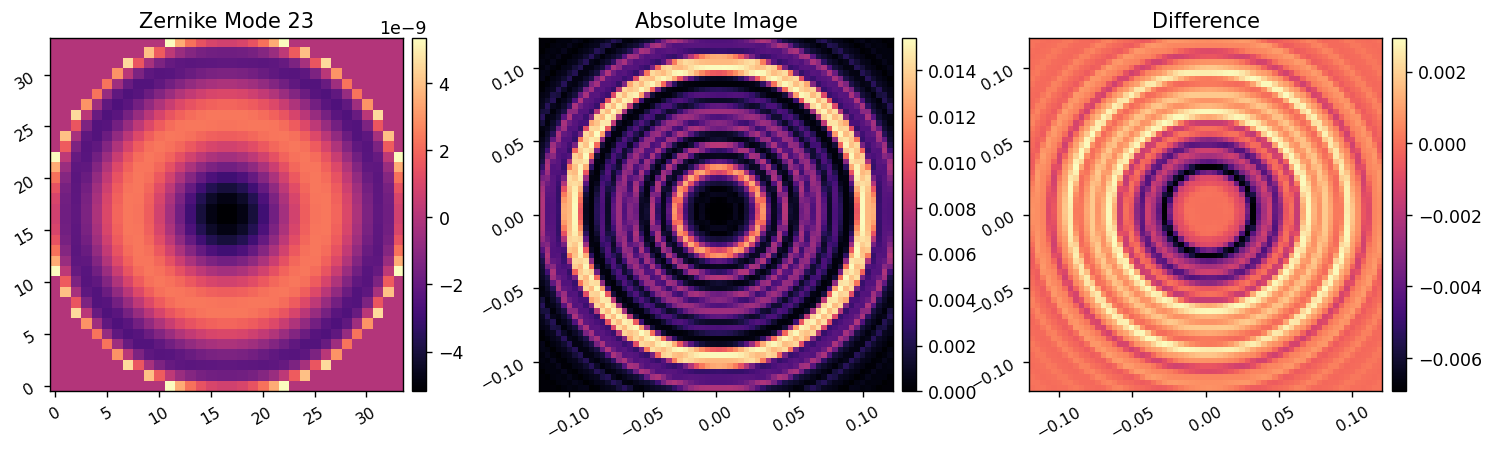

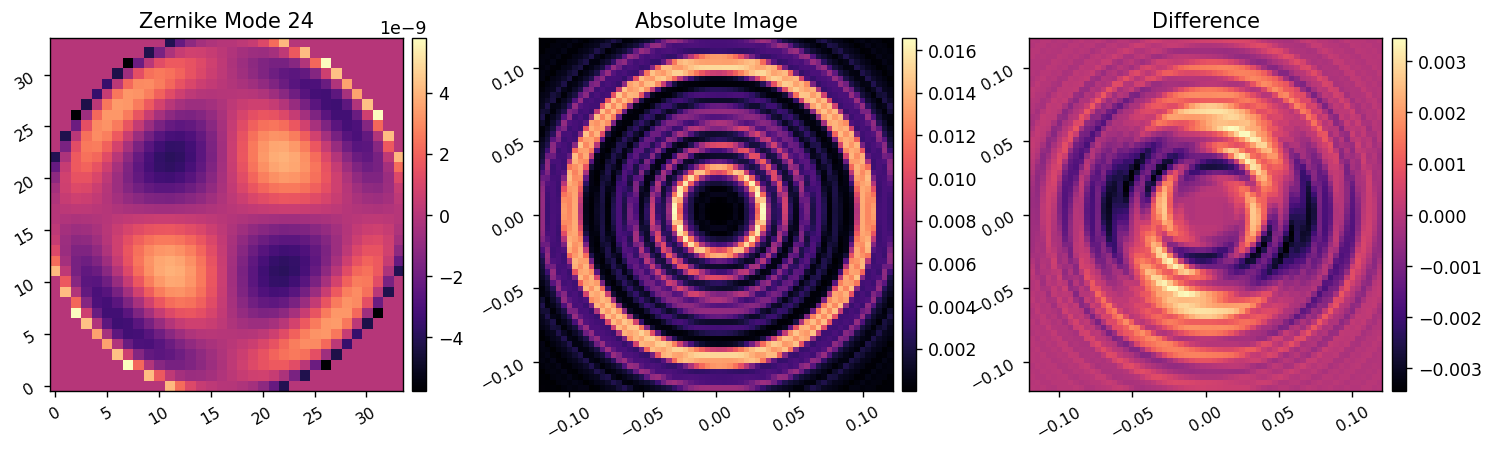

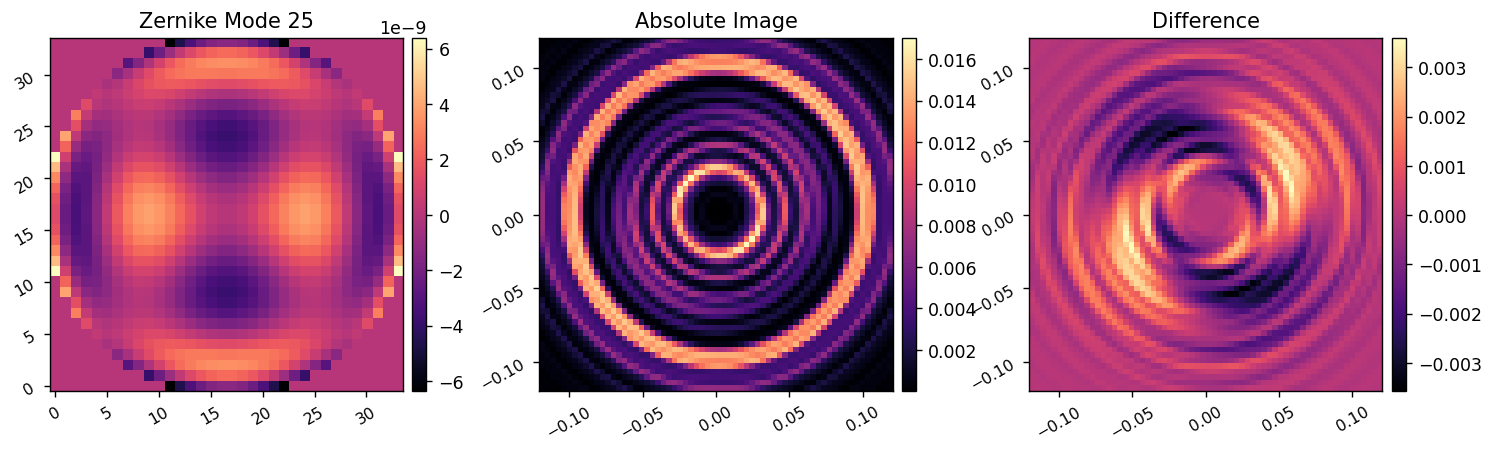

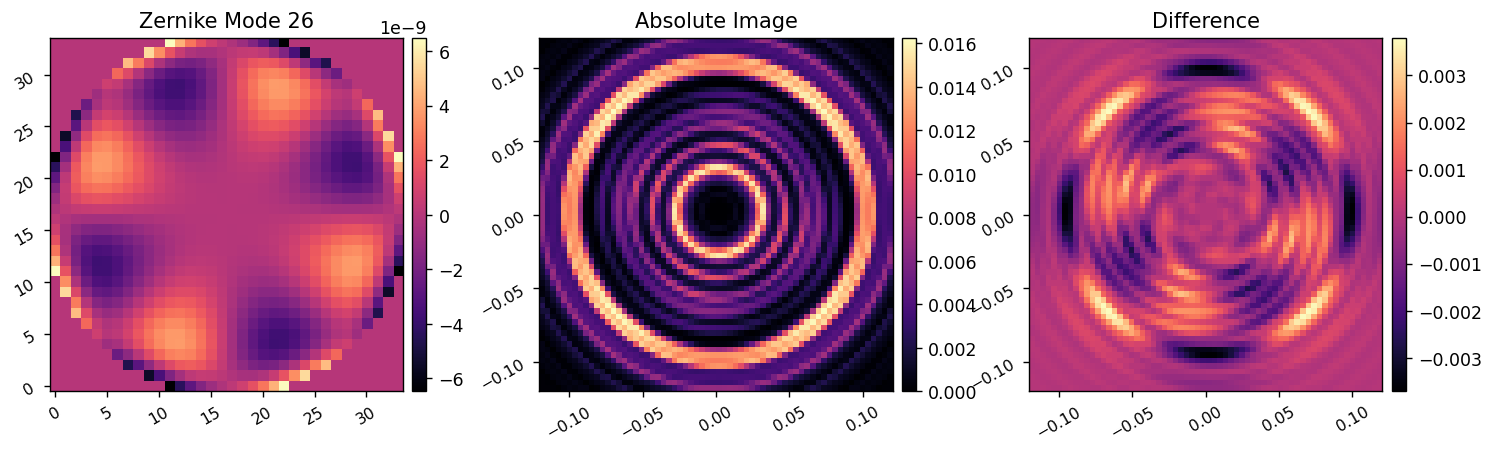

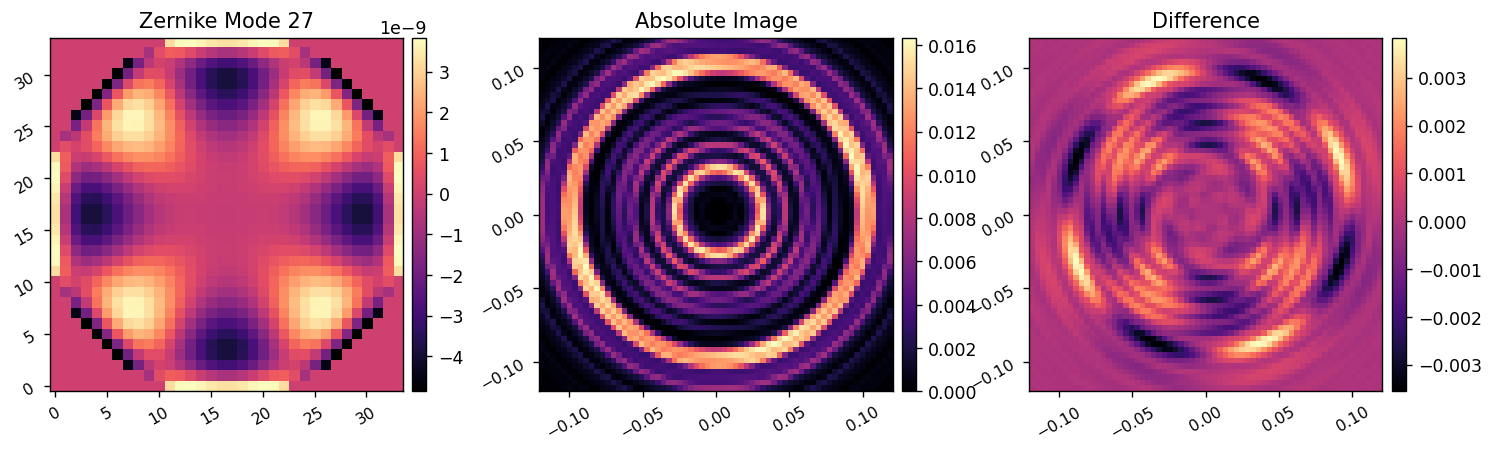

In [45]:
amp = 2e-9

im_ref = model.snap()

responses = xp.zeros((nmodes, model.nllowfsc**2))
for i,mode in enumerate(dm_zernikes):
    # model.RETRIEVED = poppy.ArrayOpticalElement(opd=mode*1e-8, pixelscale=model.pupil_diam/(2*model.npix*u.pix))
    # im_pos = model.snap()

    model.set_dm(amp*mode)
    im_pos = model.snap()
    model.add_dm(-amp*mode)
    
    # diff = im_pos-im_ref
    # responses[i] = diff.flatten()/amp
    
    model.add_dm(-amp*mode)
    im_neg = model.snap()
    model.add_dm(amp*mode)

    diff = im_pos - im_neg
    responses[i] = diff.flatten()/(2*amp)

    imshow3(amp*mode, im_pos, diff, f'Zernike Mode {i+3}', 'Absolute Image', 'Difference', 
            pxscl2=model.llowfsc_pixelscale.to(u.mm/u.pix), pxscl3=model.llowfsc_pixelscale.to(u.mm/u.pix))

response_matrix = responses.T

In [23]:
amps

array([ 9.83084776e-09, -3.90326862e-09, -5.47133550e-09,  9.91490177e-09,
        8.69202400e-09, -1.57633581e-08, -9.32058067e-10,  7.75056107e-09,
        7.60701032e-09, -4.67356699e-09, -2.25449845e-08,  8.70300656e-09,
       -6.21670933e-09,  2.11511697e-08, -1.91192621e-09,  1.39269079e-10,
        1.59697663e-08, -2.96256919e-09,  2.07101997e-09,  2.91977426e-09,
       -5.31504139e-09, -2.34859813e-09,  8.65562403e-09, -3.19377627e-09,
       -6.56902004e-09])

In [21]:


10e-9*np.random.rand(nmodes) - 5e-9

array([8.69282908e-09, 3.60420788e-09, 4.12504395e-09, 1.65731012e-09,
       4.86942510e-09, 5.85150221e-09, 4.18359242e-09, 6.60985357e-09,
       3.08752565e-10, 2.75537921e-09, 1.24909668e-09, 5.64426158e-09,
       8.36864197e-09, 2.27625019e-09, 5.22117073e-09, 4.12056969e-09,
       4.81528728e-09, 7.08095802e-09, 6.27695120e-09, 7.26704929e-09,
       2.96040275e-09, 1.63294597e-09, 5.42627020e-09, 3.02938719e-09,
       5.61082442e-09])

In [87]:
rms_lo_err = np.sqrt(np.sum(np.square(amps)))
rms_lo_err = np.sqrt(np.mean(np.square(lo_wfe[model.dm_mask])))
print(rms_lo_err)

5.205668839768331e-09


In [116]:
total_rms = 10e-9



1.6889561397771106e-08


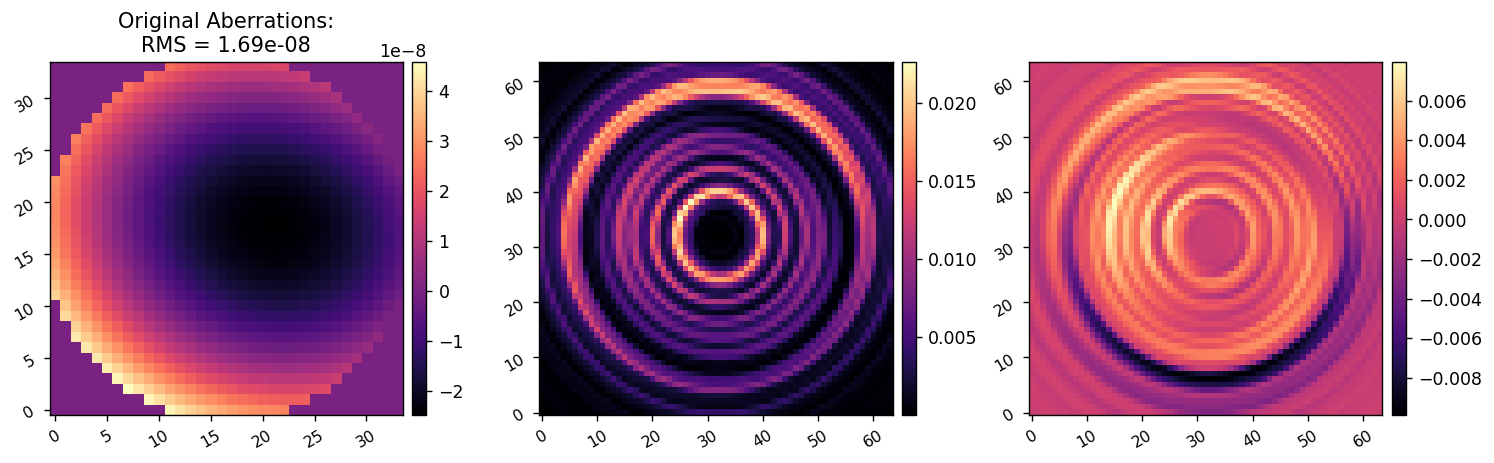

In [149]:
amps = 5e-9*(np.random.randn(5))
# amps = 1e-9*(np.random.randn(nmodes))

lo_wfe = 0
for i in range(len(amps)):
    lo_wfe += amps[i]*dm_zernikes[i]
    # lo_wfe += amps[i]*zmodes[i]

rms_lo_err = np.sqrt(np.sum(np.square(amps)))
rms_lo_err = np.sqrt(np.mean(np.square(lo_wfe[model.dm_mask])))
print(rms_lo_err)

model.set_dm(lo_wfe/2)
# model.RETRIEVED = poppy.ArrayOpticalElement(opd=lo_wfe, pixelscale=model.pupil_diam/(2*model.npix*u.pix))
model.RETRIEVED = None
im = model.snap()

diff_im = im - im_ref

imshow3(lo_wfe, im, diff_im,
        f'Original Aberrations:\nRMS = {rms_lo_err:.2e}', )

In [120]:
control_matrix.shape

(25, 4096)

In [144]:
# control_matrix = lina.utils.beta_reg(response_matrix, -10)
control_matrix = lina.utils.TikhonovInverse(response_matrix, 1e-5)

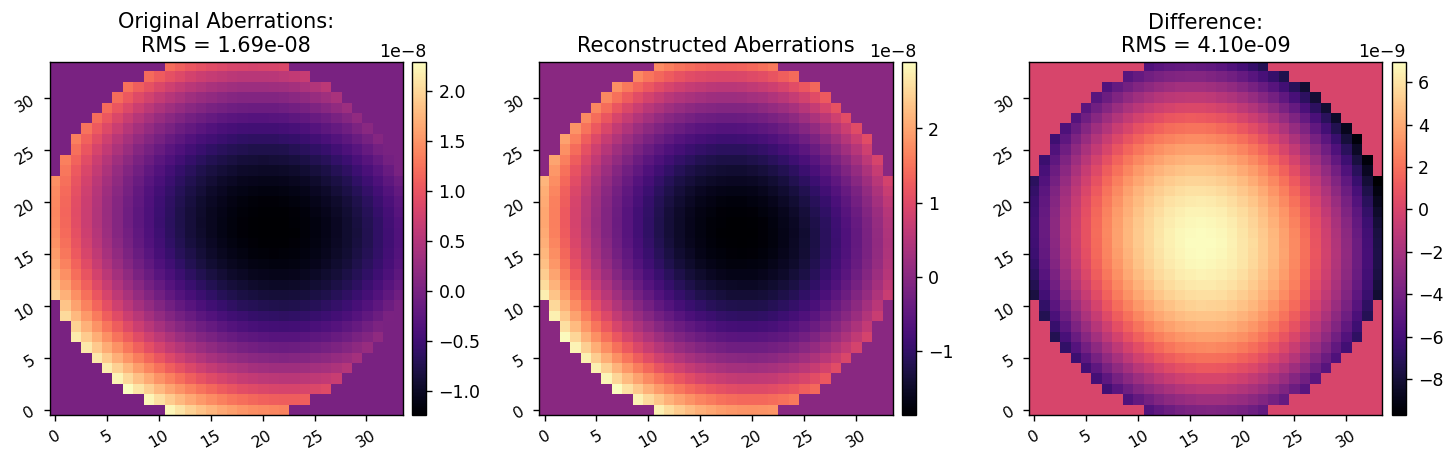

In [152]:
modal_coeff = control_matrix[:len(amps)].dot(diff_im.flatten())

est_lo_wfe = 0
for i in range(len(modal_coeff)):
    # est_lo_wfe += modal_coeff[i]*zmodes[i]
    est_lo_wfe += modal_coeff[i]*dm_zernikes[i]

diff = lo_wfe/2 - est_lo_wfe
rms_residual = np.sqrt(np.mean(np.square(diff[model.dm_mask])))

imshow3(lo_wfe/2, est_lo_wfe, diff,
        f'Original Aberrations:\nRMS = {rms_lo_err:.2e}', 
        'Reconstructed Aberrations', 
        f'Difference:\nRMS = {rms_residual:.2e}')


# make a plot for how many modes can be controlled versus the total RMS

In [96]:
U.shape, s.shape, Vt.shape

((4096, 25), (25,), (25, 25))

In [108]:
dm_zernikes[xp.argmax(control_matrix.dot(emode.flatten()))]


NameError: name 'emode' is not defined

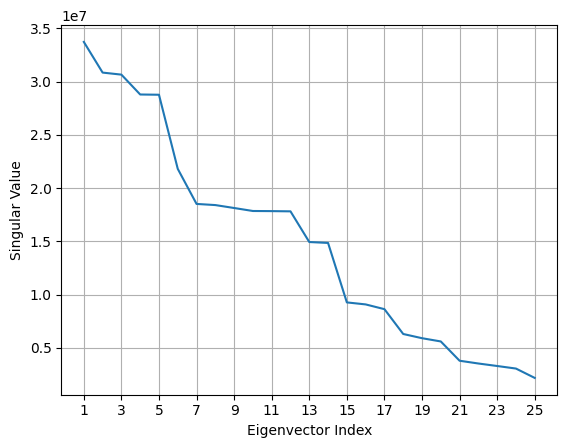

In [132]:
U, s, Vt = xp.linalg.svd(response_matrix, full_matrices=False)

plt.plot(np.arange(1,nmodes+1), ensure_np_array(s))
plt.xticks(np.arange(1,nmodes+1, 2))
plt.xlabel('Eigenvector Index')
plt.ylabel('Singular Value')
plt.grid()

# for i in range(nmodes):
#     print(s.shape)

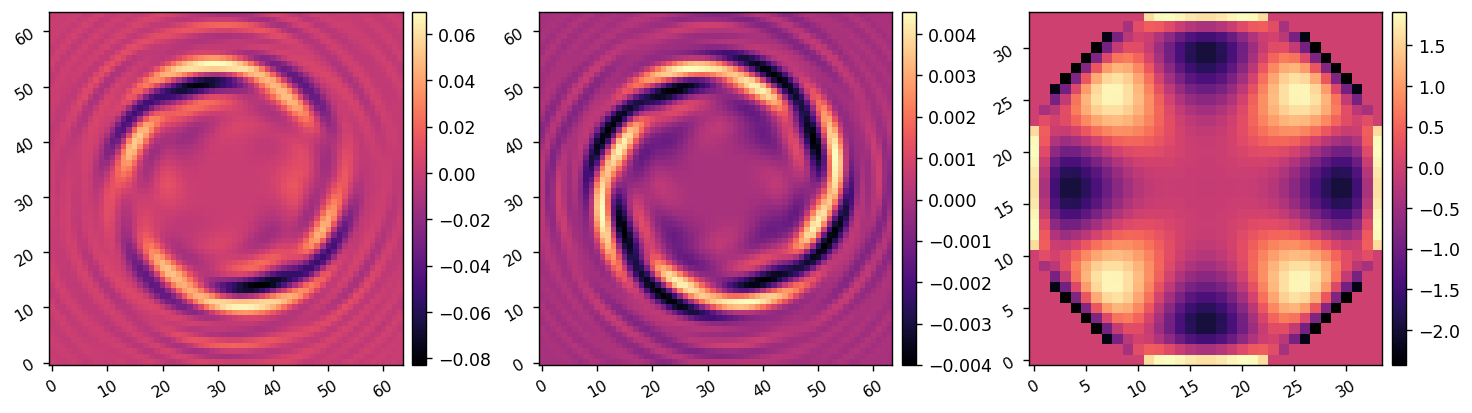

In [117]:
emode = U[:,6].reshape(model.nllowfsc, model.nllowfsc)
best_match = response_matrix.T[xp.argmax(control_matrix.dot(emode.flatten()))].reshape(model.nllowfsc, model.nllowfsc)*amp
best_mode = dm_zernikes[xp.argmax(control_matrix.dot(emode.flatten()))]
imshow3(emode, best_match, best_mode)